In [1]:
# !pip install IPython

In [2]:
# import sklearn

# print(sklearn.__version__)

### path

In [3]:
import os

# 파일이 있는 현재 위치를 path로 지정
current_directory = os.getcwd()
path = current_directory.replace('\\', '/')
path += '/' if not path.endswith('/') else ''

data_path = path + "data/"
print("Data_path :", data_path)

img_path = path + "img/"
print("IMG_path :", img_path)

#필요시 path 재조정
# path = 'C:/Users/sook7/미래에솦_주피터/본선코드정리/'
# data_path = path + "data/"
# img_path = path + "img/"

Data_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/data/
IMG_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/img/


### 글꼴

In [4]:
#windows 실행시
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# 디렉토리 및 파일 이름에 맞추어 변경
font_location = path + 'NanumGothic.ttf'
# 폰트 설정
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

#MAC 실행시
# plt.rcParams["font.family"] = "Arial Unicode MS"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE

import itertools
import joblib
import os

from IPython.display import Image
import warnings

# Jupyter Notebook에서 그래프 표시를 위해 초기화
# 해당 코드를 꼭 실행한 후 pyplot 시각화를 진행해주세요!
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# 경고 메시지 무시 설정
warnings.filterwarnings("ignore")

# 모든 칼럼 출력
pd.set_option('display.max_columns', None)

## 지표 산출시 필요한 데이터 프레임 불러오기

In [6]:
model_df = pd.read_csv(data_path + "data_전처리_model_df_ver2.csv")
data_streamlit = pd.read_csv(data_path + "data_streamlit_info.csv")

model_df["종목코드"] = model_df["종목코드"].astype(str).str.zfill(6).str.strip()
data_streamlit["종목코드"] = data_streamlit["종목코드"].astype(str).str.zfill(6).str.strip()

model_df.head(1)

,종목코드,종목명,매출액 증감율,영업이익 증감율,EPS 증감율,자산비율,부채비율,유동비율,순운전자비율,예상 시가총액,PBR,PSR,ROE,ROA,OPM,시초/공모(%),nsi_5,업황,공모주 시장 동향,유통가능물량비율,기관경쟁률,의무보유확약비율,공모금액,공모밴드비율
0,432430,와이랩,37.513947,59.464973,-226.171093,173.679148,73.679148,210.541089,41.965084,1.424822e+11,12.780448,4.784407,-5.158176,-2.956401,-1.462359,140.0,100.29,-5.199982,0.846154,37.53,1821.64,14.11,2.100000e+10,120.0


In [7]:
data_streamlit.head(1)

,기업명,예측일,공모희망가(원),공모가(원),주간사,종목코드,신규상장일,시초/공모(%),공모주일정
0,시큐레터,2023.08.08,"9,200~10,600","12,000",대신증권,418250,2023/08/24,%,2023.08.14~08.16


# Data Processing

In [8]:
continuous_columns = ['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE', 'nsi_5', '업황', '공모주 시장 동향', '유통가능물량비율', '기관경쟁률', '의무보유확약비율']
skewed_columns = []
 
# 이상치 대체  
def replace_outliers_with_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 이상치 개수 카운트
    num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    # 이상치를 3 * IQR 값으로 대체
    df[column] = np.where(df[column] < lower_bound, Q1 - 3 * IQR, df[column])
    df[column] = np.where(df[column] > upper_bound, Q3 + 3 * IQR, df[column])
    

# 각 칼럼에 대해 이상치 대체 적용
for column in continuous_columns:
    replace_outliers_with_iqr(model_df, column)

In [9]:
# 변경된 공모주 규정을 반영하기 위해 시초/공모(%)가 100%이면서 따상인 종목 분류를 위한 전처리 과정
closing_price = pd.read_csv(data_path + 'data_크롤링_38_신규상장.csv')

# merge 하기위해 변수명 통일
closing_price.rename(columns = {'기업명' : '종목명'}, inplace=True)

# numeric 타입으로 형변환
closing_price['시초/공모(%)'] = pd.to_numeric(closing_price['시초/공모(%)'].str.replace('%', ''), errors='coerce')
closing_price['시초가(원)'] = pd.to_numeric(closing_price['시초가(원)'].str.replace(',', ''), errors='coerce')
closing_price['공모가(원)'] = pd.to_numeric(closing_price['공모가(원)'].str.replace(',', ''), errors='coerce')
closing_price['첫날종가(원)'] = pd.to_numeric(closing_price['첫날종가(원)'].str.replace(',', ''), errors='coerce')

closing_price['종가/공모(%)'] = (closing_price['첫날종가(원)'] - closing_price['공모가(원)']) / closing_price['공모가(원)'] * 100
closing_price[closing_price['종가/공모(%)'] == 160]

# 수작업으로 null값 채우기 (스팩 제외)
closing_price.loc[34, '첫날종가(원)'] = 41600
closing_price.loc[70, '첫날종가(원)'] = 15600

closing_price.loc[34, '종가/공모(%)'] = (closing_price.loc[34, '첫날종가(원)'] - closing_price.loc[34, '공모가(원)']) / closing_price.loc[34, '첫날종가(원)'] * 100
closing_price.loc[70, '종가/공모(%)'] = (closing_price.loc[70, '첫날종가(원)'] - closing_price.loc[70, '공모가(원)']) / closing_price.loc[70, '첫날종가(원)'] * 100

#따상 종목은 4로 라벨링 하기 위해, model_df와 closing_price 합치기
model_df = pd.merge(model_df, closing_price[['종목명','종가/공모(%)']], on='종목명', how='left')

# 기업명과 종목코드를 별도의 데이터프레임으로 저장
company_info_df = model_df[['종목명', '종목코드']]

# 기업명과 종목코드를 제외한 데이터프레임 생성
model_df = model_df.drop(['종목명', '종목코드'], axis=1)

In [10]:
#다중분류 4개 범주
def split_multi_y(row):
    if row['시초/공모(%)'] <= 20:
        return 0
    elif row['시초/공모(%)'] <= 60:
        return 1
    elif row['시초/공모(%)'] < 100:
        return 2
    elif row['시초/공모(%)'] == 100:
        if not row['종가/공모(%)'] > 158:
            return 2
        else:
            return 3
    # 시초/공모(%)가 100을 넘는 경우(기준 개편 이후)
    else:
        return 3

y = model_df.apply(split_multi_y, axis=1)                                        
                              
# 독립변수 설정
X = model_df.drop(['시초/공모(%)','종가/공모(%)'], axis=1)

In [11]:
# 독립변수 설정
X = model_df.drop(['시초/공모(%)', '종가/공모(%)','영업이익 증감율', '부채비율', '순운전자비율', 'PBR', 'ROA', 'OPM', '공모금액', "공모밴드비율"], axis=1)

In [12]:
# 다중 분류 Class의 수
num_class = 4

# 결과 재현성 및 모델 평가의 일관성을 위해 random_state 지정
random_state = 723

# 표준화
scaler = StandardScaler()
columns_to_scale = X.columns
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# 클래스의 불균형이 있어 데이터 분할시 클래스 레이블 분포를 유지하기 위해 stratify=y 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=random_state)

# Borderline-SMOTE를 사용하여 오버샘플링
borderline_smote = BorderlineSMOTE(random_state = random_state)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)

# 지표 산출
### 1) 지표 산출 산식
1. 모든 Label에 대해 Label값과 predict_proba() method를 통해 산출된 확률값을 곱한 후 합산해준다.
2. 100점 척도로 바꿔주기위해 100/3을 곱해주어 scale을 늘려준다.

-> 공모주 종합 평가 점수 도출 완료!

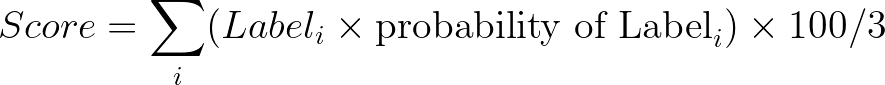

In [13]:
Image(filename = img_path +'지표산출산식.png')

### 2) 지표 산출 방법론
- predict_proba() method를 활용하여 위의 산식을 통해 공모주 종합 평가 점수를 산출하였다. 만약 예측한 범주의 값만을 활용하여 점수를 도출했을 경우 같은 범주로 예측된 기업간의 유의미한 차이를 확인하기 어려워 확률론적 방법을 활용하여 같은 범주내에서도 시초/공모(%)에 더 좋은 영향을 주는 기업에 대해 높은 점수를 줄 수 있도록 구상하였다.

## 공모주 종합 평가 점수와 각 F, T, A 지표를 도출할 Final model load

In [14]:
# 모델 로드하기
Final_classifier = joblib.load(data_path + 'Final_voting.pkl')
F_classifier = joblib.load(data_path + 'F_voting.pkl')
T_classifier = joblib.load(data_path + 'T_catboost.pkl')
A_classifier = joblib.load(data_path + 'A_voting.pkl')

## 1. 공모주 종합 평가 점수 도출
- F, T, A의 모든 변수를 활용하여 도출한 점수
- Final_model은 'Final_voting.pkl'이고 XGBClassifier, RandomForestClassifier를 Soft Voting한 앙상블 모델이다.

#### 공모주 종합 평가 점수 활용
- 공모주 청약 판단의 main 지표
- 공모주 종합 평가 점수를 통해 청약 권장도를 만들어 신규상장 종목에 대한 청약등급을 설정
- 청약위험(0-25), 청약중립(25-45), 청약권장(45-70), 청약추천(70-100)
- 공모주 종합 평가 점수를 활용해 청약 등급을 나타내주는것은 Streamlit 구현 코드에 있습니다!

In [15]:
# F, T, A 모든 변수를 포함한 최종 모델을 통해 산출한 공모주 종합 평가 점수 도출
score_df = pd.DataFrame()
score_df['기업명'] = company_info_df['종목명']
score_df['종목코드'] = company_info_df['종목코드']
score_df['시초/공모(%)'] = model_df['시초/공모(%)']

total_prob = Final_classifier.predict_proba(X)
model_score = np.sum(total_prob * np.array([0, 1, 2, 3]), axis=1)
score_df['model_score'] = model_score * 100/3

## 2. F, T, A 지표 도출
### F, T, A 지표를 각각 도출 하는 이유
- F, T, A 지표를 각각 도출하여 해당 기업이 어떤 분야에 강점을 가진 기업인지를 확인 할 수 있다. 공모주 종합 평가 점수만을 확인하게된다면 해당 기업이 F(재무정보)에 강점이 있어서 점수가 높은지, T(시장동향), A(기관)에 강점이 있어서 점수가 높은지 확인할 수 없다. 고객별로 유의미하게 생각하는 분야가 다르기에 고객이 공모주 청약 판단을 할 때, 추가적으로 투자 판단에 도움을 주기위한 부가서비스이다.  
ex) F(재무), T(시장동향)보다 A(기관)만을 중요하게 판단하여 공모주 청약을 진행하는 고객이 많다. 우리의 서비스는 공모주 청약 판단에 도움을 주는 지표를 개발하는 것이기에 고객의 needs를 만족할 수 있도록 F, T, A 지표를 도출하였다.

- 과거 유사 종목 비교 서비스 : F, T, A 지표는 과거 유사 종목 비교 서비스에 활용된다. 공모주 종합 평가점수, F_score, T_score, A_score 4가지 항목을 고려하여 과거 상장된 공모기업과의 유클라디안 유사도를 통해 유사도가 높은 상위 2개 종목을 보여주어 공모주 종합 평가 점수 뿐만아니라 F, T, A의 구성까지 유사한 종목을 보여주어 투자판단에 도움을 줄 예정이다.

### 2-1. F_score
- F : Finance 변수만을 활용하여 도출한 점수
- 사용한 F 변수 목록 : '매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE'
- Final_model은 'F_voting.pkl'이고 LogisiticRegression, RandomForestClassifier를 Soft Voting한 앙상블 모델이다.
- 지표 도출 과정은 공모주 종합 평가 점수 도출 과정과 같다.

In [16]:
# f_score
f_prob = F_classifier.predict_proba(X[['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE']])
f_score = np.sum(f_prob * np.array([0, 1, 2, 3]), axis=1)
score_df['f_score'] = f_score * 100/3

### 2-2. T_score
- T : Trend 변수만을 활용하여 도출한 점수
- 사용한 T 변수 목록 : 'nsi_5', '업황','공모주 시장 동향'
- Final_model은 'T_catboost.pkl'이고 CatboostClassifier를 사용한 단일 모델이다.

- 지표 도출 과정은 공모주 종합 평가 점수 도출 과정과 같다.

In [17]:
# t_score
t_prob = T_classifier.predict_proba(X[['nsi_5', '업황','공모주 시장 동향']])
t_score = np.sum(t_prob * np.array([0, 1, 2, 3]), axis=1)
score_df['t_score'] = t_score * 100/3

### 2-3. A_score
- A : Agent 변수만을 활용하여 도출한 점수
- 사용한 A 변수 목록 : '유통가능물량비율', '기관경쟁률', '의무보유확약비율'
- Final_model은 'A_voting.pkl'이고 RandomForestClassifier, CatBoostClassifier를 Soft Voting한 앙상블 모델이다.

- 지표 도출 과정은 공모주 종합 평가 점수 도출 과정과 같다.

In [18]:
# a_score
a_prob = A_classifier.predict_proba(X[['유통가능물량비율', '기관경쟁률', '의무보유확약비율']])
a_score = np.sum(a_prob * np.array([0, 1, 2, 3]), axis=1)
score_df['a_score'] = a_score * 100/3

In [19]:
# 최종 예측 범주
score_df['범주'] = Final_classifier.predict(X)

## data_streamlit_df 생성이유
- data_streamlit_df : Streamlit을 활용하여 웹페이지 구축을 위한 정보를 담은 csv
- Final_model로 도출한 지표 + 기업에 대한 정보

#### code_indicator.ipynb의 흐름
- input : data_streamlit_info.csv, model_df
- output : data_streamlit_df.csv
-> 지표를 산출하여 streamlit에 사용할 Final csv 파일을 생성

In [20]:
data_streamlit_df = pd.merge(data_streamlit.drop(["시초/공모(%)"], axis=1), score_df.drop(["기업명"], axis=1), on="종목코드", how="right")
#data_streamlit_df.to_csv(path + "data_streamlit_df.csv", index=False)
data_streamlit_df.head(3)

,기업명,예측일,공모희망가(원),공모가(원),주간사,종목코드,신규상장일,공모주일정,시초/공모(%),model_score,f_score,t_score,a_score,범주
0,와이랩,2023.07.03,"7,000~8,000","9,000",한국투자증권,432430,2023/07/20,2023.07.10~07.11,140.00,84.111564,63.224834,94.461735,94.324857,3
1,파로스아이바이오,2023.07.10,"14,000~18,000","14,000",한국투자증권,388870,2023/07/27,2023.07.17~07.18,-11.93,17.026243,41.525908,8.776436,9.557506,0
2,버넥트,2023.07.10,"11,500~13,600","16,000",대신증권,438700,2023/07/26,2023.07.17~07.18,47.50,37.339541,46.045983,31.679119,37.987186,1


# 데이터 시각화

### test셋에 대한 시각화를 위해 test셋 데이터프레임 구성
- score_df : 학습데이터 + 테스트데이터
- test_df : 테스트데이터

In [21]:
test_df = pd.DataFrame()
test_df['기업명'] = company_info_df['종목명'].iloc[X_test.index]
test_df['종목코드'] = company_info_df['종목코드'].iloc[X_test.index]
test_df['시초/공모(%)'] = model_df['시초/공모(%)'].iloc[X_test.index]

test_prob = Final_classifier.predict_proba(X_test)

test_score = np.sum(test_prob * np.array([0, 1, 2, 3]), axis=1)
test_df['test_score'] = test_score * 100/3
test_df["범주"] = Final_classifier.predict(X_test)

test_df.head(3)

,기업명,종목코드,시초/공모(%),test_score,범주
472,서플러스글로벌,140070,6.25,15.736777,0
439,덕우전자,263600,9.03,24.352658,0
444,힘스,238490,62.50,54.464180,2


In [22]:
# 3년전, 5년전과 같은 시계열 데이터에 대한 시각화를 위해 score_df와 test_df에 신규상장일 칼럼을 추가
# 공모주 종합 평가 점수와 시초/공모(%)의 상관관계를 확인할 예정

data_신규상장일 = data_streamlit[["종목코드", "신규상장일"]]

score_df = pd.merge(score_df, data_신규상장일, on="종목코드", how="left")
test_df = pd.merge(test_df, data_신규상장일, on="종목코드", how="left")

In [23]:
# 시각화에 도움이 되도록 예측일 기준 내림차순 정렬
score_df["신규상장일"] = pd.to_datetime(score_df["신규상장일"])
test_df["신규상장일"] = pd.to_datetime(test_df["신규상장일"])

test_df = test_df.sort_values(by="신규상장일", ascending=False)
test_df.reset_index(drop=True, inplace=True)

score_df.head(3)

,기업명,종목코드,시초/공모(%),model_score,f_score,t_score,a_score,범주,신규상장일
0,와이랩,432430,140.00,84.111564,63.224834,94.461735,94.324857,3,2023-07-20
1,파로스아이바이오,388870,-11.93,17.026243,41.525908,8.776436,9.557506,0,2023-07-27
2,버넥트,438700,47.50,37.339541,46.045983,31.679119,37.987186,1,2023-07-26


In [24]:
test_df.head(3)

,기업명,종목코드,시초/공모(%),test_score,범주,신규상장일
0,파로스아이바이오,388870,-11.93,17.026243,0,2023-07-27
1,엘비인베스트먼트,309960,27.45,50.306096,1,2023-03-29
2,자람테크놀로지,389020,100.00,68.823814,2,2023-03-07


#### test_df의 종목코드를 기준으로 score_df에서 학습데이터와 테스트데이터를 각각 라벨링

In [25]:
test_df_code = test_df['종목코드'].unique()

# score_df에서 test_df_index 열을 추가하고 초기값으로 "train" 설정
score_df["test_df_index"] = "train"

# 종목코드가 test_df_code에 있는 경우 test로 설정
score_df.loc[score_df['종목코드'].isin(test_df_code), 'test_df_index'] = "test"

### 학습데이터의 구축일 : 2009/01/01 ~ 2023/07/31

- three_years_ago_index : 최근 3년 데이터 인덱스 (2020/08/01 ~ 2023/07/31)
- before_2015_index : 2015년 이전 데이터 인덱스 (2009/01/01 ~ 2014/12/31)

In [26]:
# 최근 3년 score_df의 인덱스
three_years_ago_index = score_df[score_df['신규상장일'] > '2020-07-31'].index

# 2015년 이전 score_df의 인덱스
before_2015_index = score_df[score_df['신규상장일'] < '2014-12-31'].index

# 1. 시초/공모(%)와 학습데이터, 테스트데이터의 상관관계 확인
- 학습데이터에 대한 예측과 테스트데이터에 대한 예측의 정확도를 비교

## 1-1. 2015년 이전 데이터에 대한 시각화

In [27]:
fig = px.scatter(
    score_df.loc[before_2015_index, :], x='model_score', y='시초/공모(%)', color='test_df_index',
    title='2015년 이전 데이터',
    labels={'model_score': 'model_score', '시초/공모(%)': '시초/공모(%)'},
    color_discrete_map={'train': 'blue', 'test': 'orange'}
)

fig.update_layout(width=800, height=600)
fig.show()

## 1-2. 최근 3년 데이터에 대한 시각화
- 2010년대 초, 중반에는 공모주 시장이 활성화 되어있지 않아 기관투자자들의 관심도 또한 저조했다. 그렇기에 가장 중요한 변수인 A(Agent)변수 또한 과거로 갈수록 의미가 퇴색된다. 위의 그래프에서도 최근 시계열로 갈수록 테스트 데이터의 model_score가 시초/공모(%)와 강한 양의 상관관계를 보임을 알 수 있다.

In [28]:
fig = px.scatter(
    score_df.loc[three_years_ago_index, :], x='model_score', y='시초/공모(%)', color='test_df_index',
    title='최근 3년 데이터',
    labels={'model_score': 'model_score', '시초/공모(%)': '시초/공모(%)'},
    color_discrete_map={'train': 'blue', 'test': 'orange'}
)

fig.update_layout(width=800, height=600)
fig.show()

# 2. 시초/공모(%)와 테스트 셋에 대한 상관관계
- 시초/공모(%)와 테스트셋에 대한 상관 관계를 확인
- 예측이 틀린 종목에 대한 확인 및 피드백
- 시초/공모(%)와 test_score간의 회귀선의 설명력을 확인
- 공모주 규정 변경을 반영한 마지막 군집에 대한 예측이 잘 되었는지 확인



In [29]:
test_df.head(3)

,기업명,종목코드,시초/공모(%),test_score,범주,신규상장일
0,파로스아이바이오,388870,-11.93,17.026243,0,2023-07-27
1,엘비인베스트먼트,309960,27.45,50.306096,1,2023-03-29
2,자람테크놀로지,389020,100.00,68.823814,2,2023-03-07


## 2-1. 최근 3년 test 데이터에 대한 데이터 시각화

#### 최근 3년 test 데이터의 test_score와 시초/공모(%)의 Scatter Plot : 예외처리 전
- 대부분의 test data를 정확히 분류하였지만 0번 군집으로 분류가 되었지만 100%의 시초/공모(%)를 기록한 2개의 기업과 3번군집으로 분류되었지만 33.14% 시초/공모(%)를 기록한 1개의 기업이 이상치로 확인되었다.

In [30]:
test_df_three_index = test_df[test_df['신규상장일'] > '2020-07-31'].index

fig = px.scatter(
    test_df.iloc[test_df_three_index,:], x='test_score', y='시초/공모(%)', color="범주",
    title='최근 3년 test 데이터의 test score와 시초/공모(%)의 Scatter Plot : 예외처리 전',
    trendline='ols',
    trendline_color_override="#043B72",
    color_discrete_sequence=['#F58220']
)

fig.show()

### 예외처리 전 회귀선의 설명력 R^2 = 0.53
- 결정계수 값은 회귀선 위에 마우스를 올리면 보입니다!

#### 왼쪽 상단의 이상치 : 고바이오랩, 티앤엘

In [31]:
test_df.iloc[test_df_three_index,:][(test_df["test_score"] < 20) & (test_df["시초/공모(%)"]>90)]

,기업명,종목코드,시초/공모(%),test_score,범주,신규상장일
43,티앤엘,340570,100.0,8.735783,0,2020-11-20
44,고바이오랩,348150,100.0,8.378190,0,2020-11-18


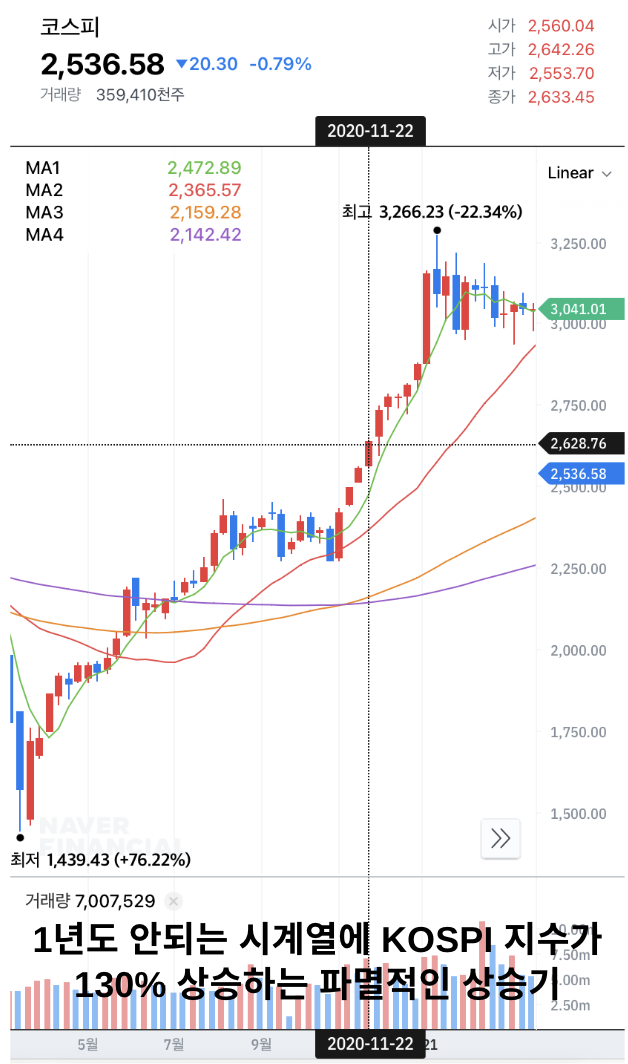

In [32]:
Image(filename = img_path +'고바이오랩_티앤앨_코스피.png')

파멸적인 상승기로 인하여 묻지도 따지지도 않고 오르던 시기에 기업의 가치평가가 제대로 이루어지지 않아 생긴 이상치

#### 오른쪽 하단의 1개의 이상치 : 씨이랩

In [33]:
test_df.iloc[test_df_three_index,:][(test_df["test_score"] > 60) & (test_df["시초/공모(%)"] < 40)]

,기업명,종목코드,시초/공모(%),test_score,범주,신규상장일
41,씨이랩,189330,33.14,68.949923,3,2021-02-24


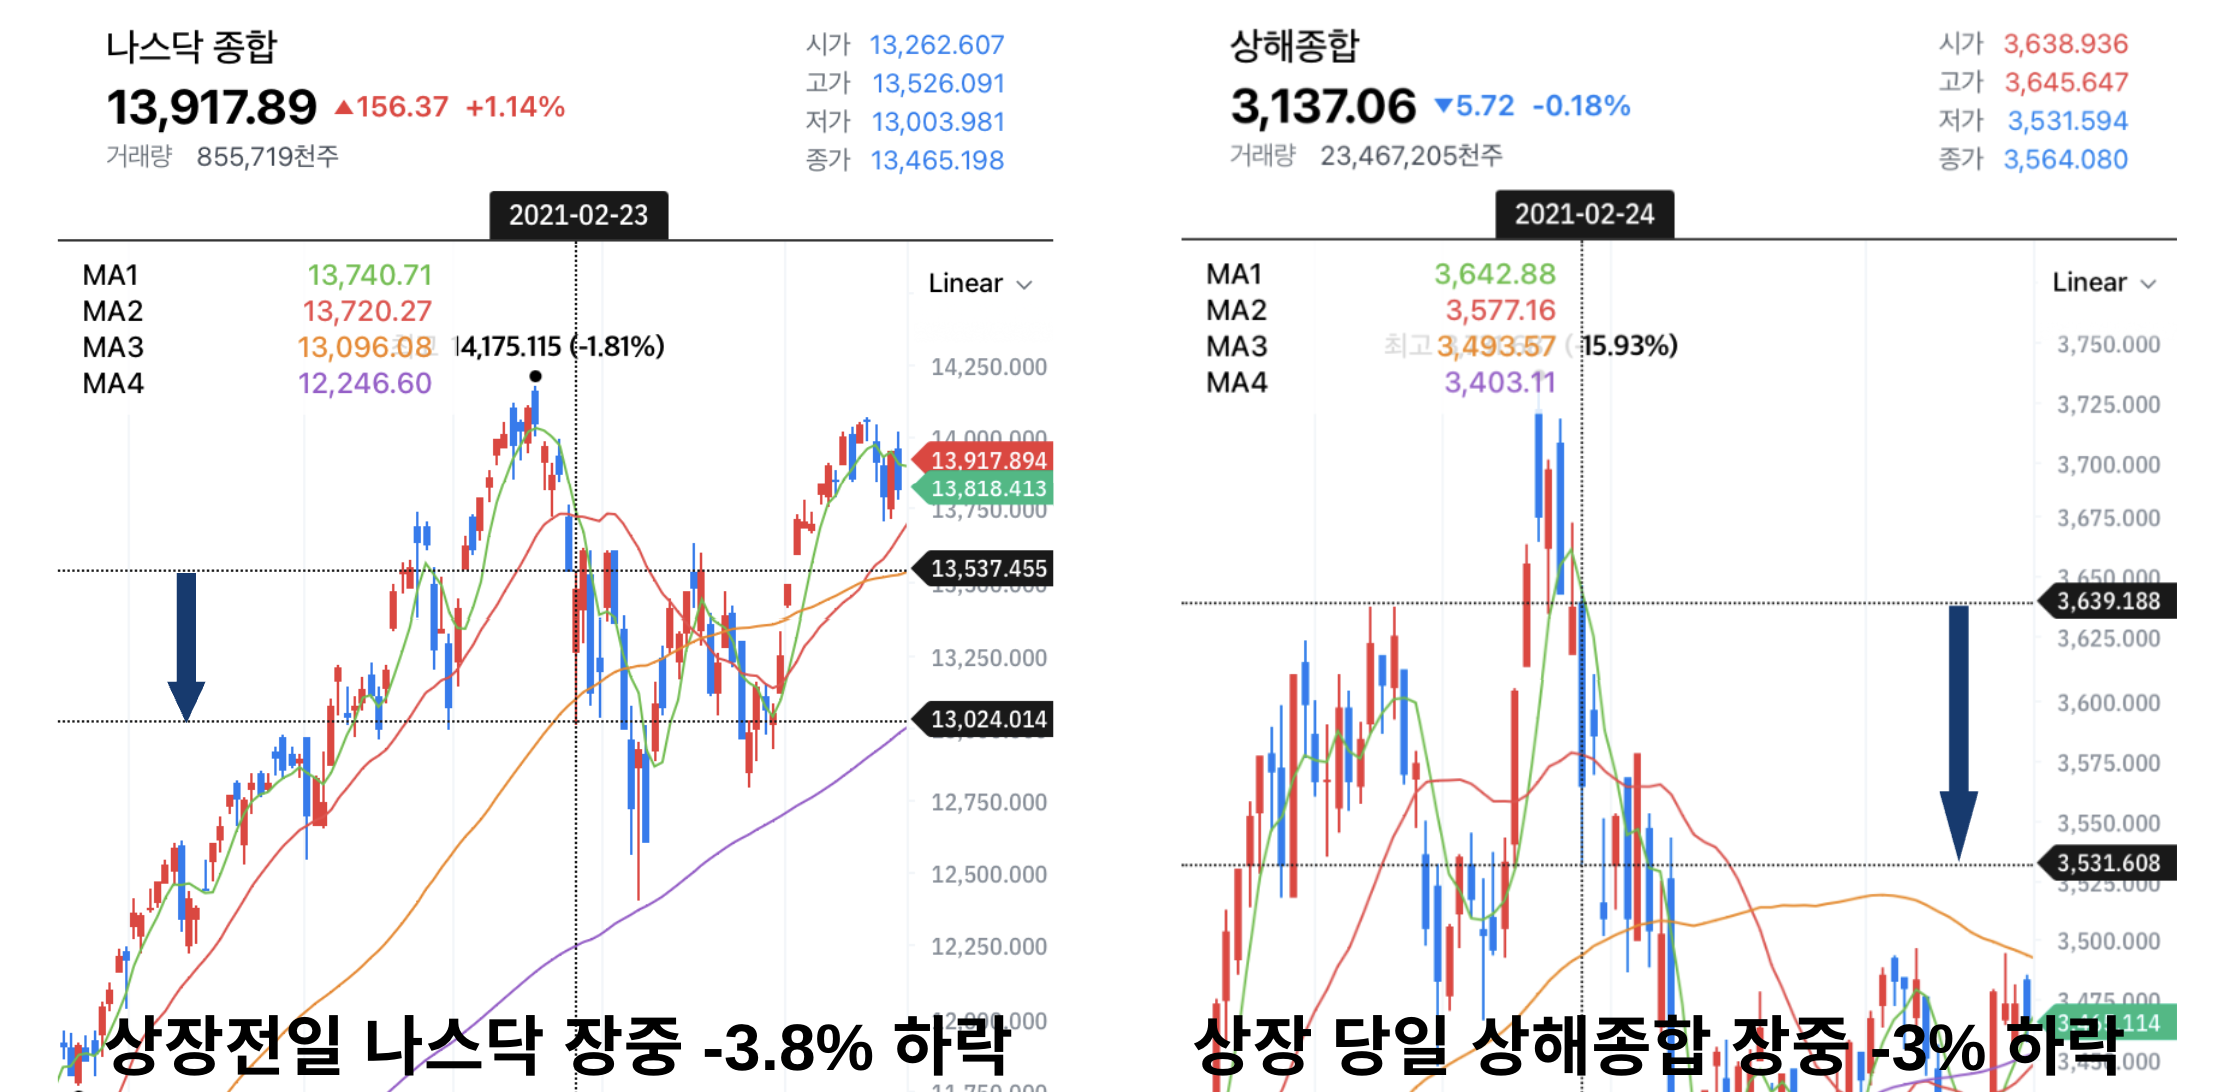

In [34]:
Image(filename = img_path +'씨이랩_나스닥_상해종합.png')

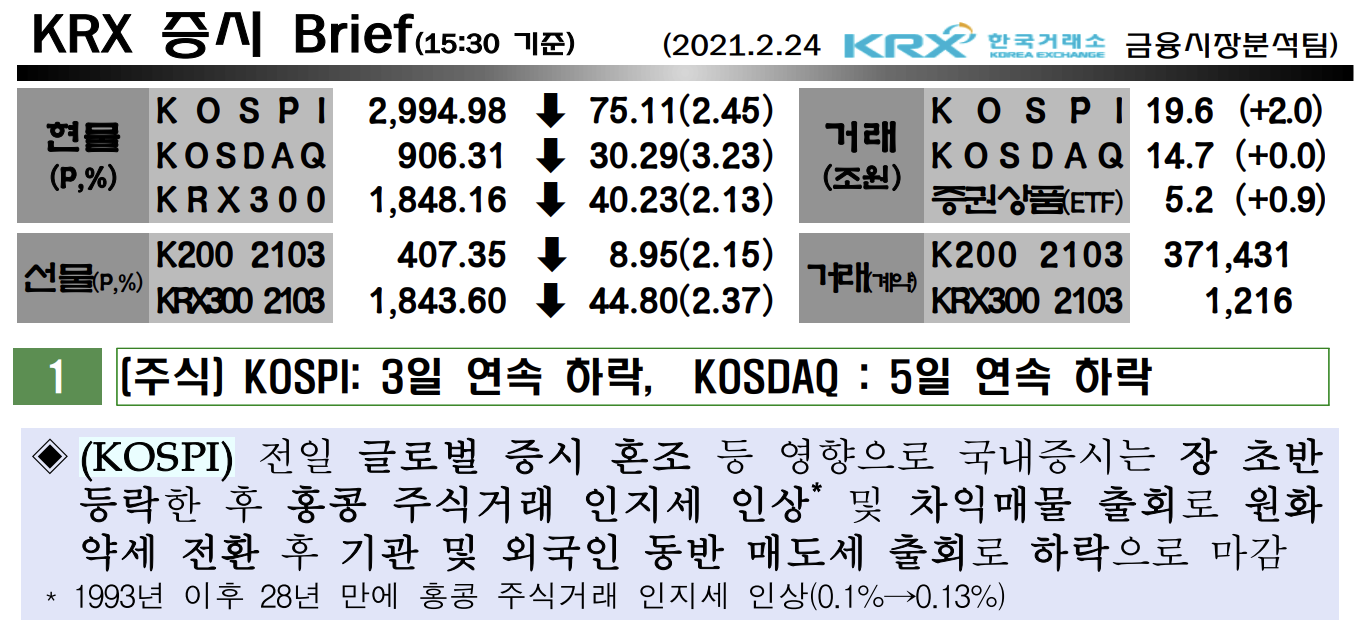

In [35]:
Image(filename = img_path +'20210224_KRX증시Brief.png')

#### 본 프로젝트는 공모가 대비 시초가의 수익률을 예측하는 프로젝트이기에 전일 나스닥의 영향을 가장 많이 받는다. 상장 전일 나스닥이 장중 -3.8%를 기록하며 불확실성을 키웠고 상장 당일 중국 증시 또한 장중 -3%를 기록하면서 상장 당시 시장이 매우 안좋았음을 알 수 있다. KRX에서 제공하는 증시 Brief를 보더라도 국내 거래소가 연속 하락을 기록하는 등 시장에 영향을 많이 받은 것 같다. 

-> 발전 방향 : 국내 시장과 공모주가 속해있는 산업에 대한 시장동향만을 살펴보았는데 공모가 대비 시초가의 수익률을 예측하는 프로젝트의 특성상 1일전 나스닥 수익률을 새로운 파생변수로 추가하면 좋을 것 같다.

#### 최근 3년 test 데이터의 test_score와 시초/공모(%)의 Scatter Plot : 예외처리 후

In [36]:
test_df_drop = test_df.drop([41, 43, 44])

In [37]:
fig = px.scatter(
    test_df_drop.iloc[test_df_three_index,:], x='test_score', y='시초/공모(%)', color="범주",
    title='최근 3년 test 데이터의 test score와 시초/공모(%)의 Scatter Plot : 예외처리 후',
    trendline='ols',
    trendline_color_override="#043B72",
    color_discrete_sequence=['#F8ECE0'],
)

fig.show()

### 예외처리 후 회귀선의 설명력 R^2 = 0.76

예외 처리 후 결정계수가 0.53 -> 0.76으로 회귀선의 설명력이 급증했음을 알 수 있다.  
  
시장에 큰 변동이 없을 경우에 예측을 하는 부분에선 모델의 일반화가 잘된 것 같다. 하지만 시장이 크게 변동할때, 변동성을 잡아내지 못하는 것을 보았고 개선 방법을 생각해봐야 할 것 같다.

### 공모주 규정 변경을 반영한 마지막 군집에 대한 예측이 잘 되었는지 확인

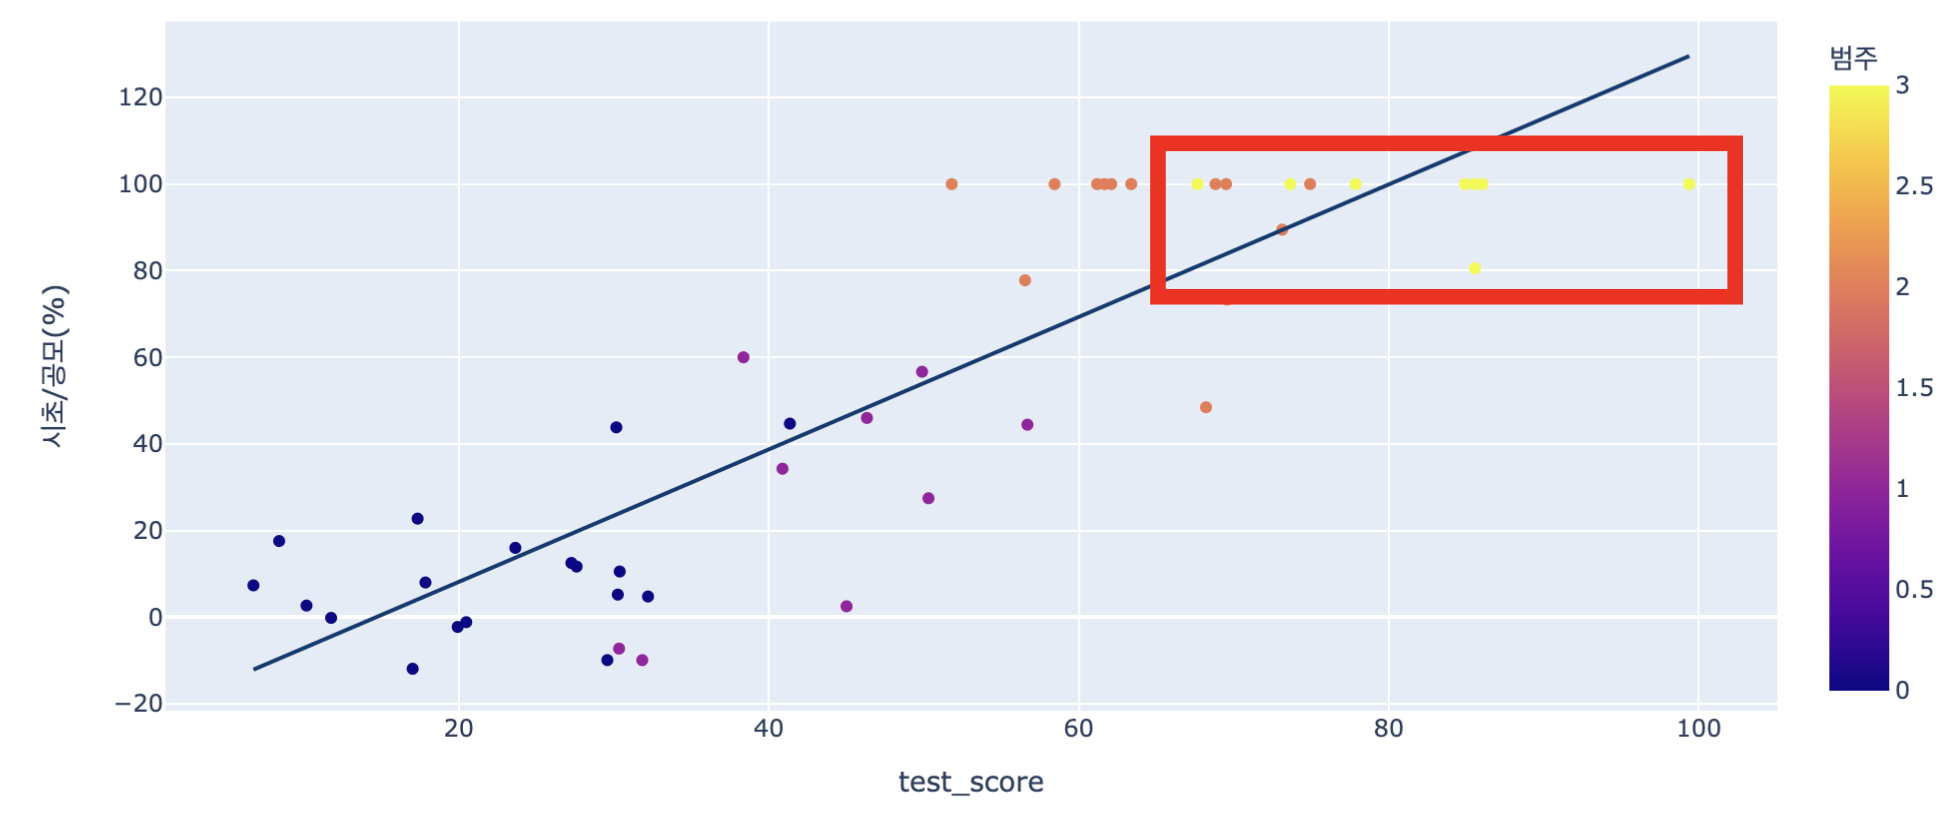

In [38]:
Image(filename = img_path +'공모주규정변경_마지막군집.png')

공모주 규정 변경전 가격 제한폭으로 인해 신규상장일에 적정한 가격을 찾지 못한 기업들을 마지막 범주(100% 초과)로 분류하는 예외처리가 잘 적용된것으로 보인다.

## -> 변경된 공모주 규정 또한 잘 반영하는 모델과 지표를 구축!